In [1]:
import numpy as np
import pandas as pd
import lxml.etree as etree
import sqlite3 as sql
from process import *
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_recall_fscore_support, precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

In [3]:
data = pd.read_csv('../data/prem_data_elo.csv', index_col = 'Unnamed: 0')
data.head()

,match_api_id,league_id,date,home_team_api_id,home_team_name,away_team_api_id,away_team_name,home_team_goal,away_team_goal,home_team_foul_reason_from_behind,...,away_team_card_reason_pushing,home_team_card_reason_diving,away_team_card_reason_diving,home_team_card_reason_hands,away_team_card_reason_hands,home_team_card_reason_Removing Shirt,away_team_card_reason_Removing Shirt,result,home_elo,away_elo
0,489044,1729,2008-08-16 00:00:00,8472,Sunderland,8650,Liverpool,0,2,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,L,1600.0,1600.0
1,489045,1729,2008-08-16 00:00:00,8654,West Ham United,8528,Wigan Athletic,2,4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,L,1600.0,1600.0
2,489047,1729,2008-08-16 00:00:00,8668,Everton,8655,Blackburn Rovers,2,12,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,L,1600.0,1600.0
3,489048,1729,2008-08-16 00:00:00,8549,Middlesbrough,8586,Tottenham Hotspur,2,4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,L,1600.0,1600.0
4,489049,1729,2008-08-16 00:00:00,8559,Bolton Wanderers,10194,Stoke City,3,4,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,L,1600.0,1600.0


In [4]:
X = data[data.columns[9:]].drop(
    ['result', 'home_elo', 'away_elo'],
axis = 1)
y = data['result']

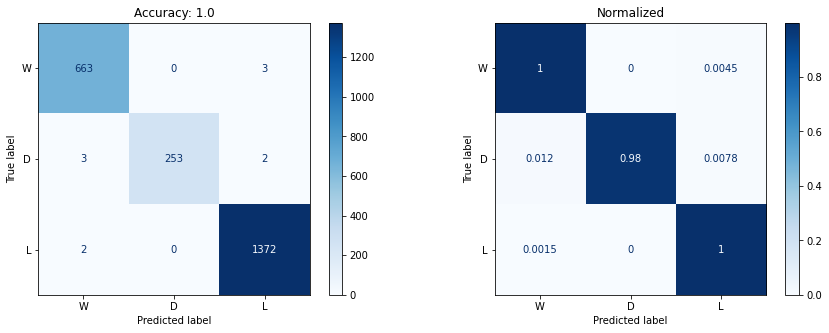

   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.995495   0.992515  0.995495  0.994003      666
1      D  0.980620   1.000000  0.980620  0.990215      258
2      L  0.998544   0.996369  0.998544  0.997455     1374
3  Total  0.995648   0.995660  0.995648  0.995642     2298


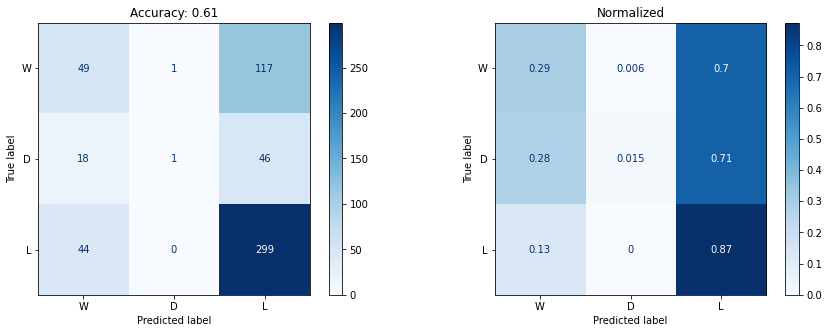

   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.293413   0.441441  0.293413  0.352518      167
1      D  0.015385   0.500000  0.015385  0.029851       65
2      L  0.871720   0.647186  0.871720  0.742857      343
3  Total  0.606957   0.570792  0.606957  0.548888      575


In [17]:
np.random.seed(1)

size = np.min(np.unique(y, return_counts = True)[1])
X_s = StandardScaler().fit_transform(X)

# Stratify takes 75% from each class, works if we fix imbalance in original data
X_train, X_test, y_train, y_test = train_test_split(X_s, y, test_size = 0.2, stratify = y)
pd.DataFrame(np.array(np.unique(y, return_counts = True)).T, columns = ['Label', 'n']).sort_values(by = 'n')

clf = RandomForestClassifier(class_weight = weights).fit(X_train, y_train)

print(metric_suite(clf, X_train, y_train))
print(metric_suite(clf, X_test, y_test))

In [36]:
np.random.seed(1)

size = np.min(np.unique(y, return_counts = True)[1])
X_s = StandardScaler().fit_transform(X)
W = np.random.choice(np.arange(y.shape[0])[y == 'W'], size = size)
D = np.random.choice(np.arange(y.shape[0])[y == 'D'], size = size)
L = np.random.choice(np.arange(y.shape[0])[y == 'L'], size = size)

idx = [W, D, L]
new_idx = np.concatenate(idx)
X_i = X_s[new_idx]
y_i = y[new_idx]

weights = {}
for i, class_ in enumerate(['W', 'D', 'L']):
    weights[class_] = y[y == class_].shape[0]/len(idx[i])

# Stratify takes 75% from each class, works if we fix imbalance in original data
X_train, X_test, y_train, y_test = train_test_split(X_i, y_i, test_size = 0.2, stratify = y_i)
print(weights)
pd.DataFrame(np.array(np.unique(y_i, return_counts = True)).T, columns = ['Label', 'n']).sort_values(by = 'n')

{'W': 2.5789473684210527, 'D': 1.0, 'L': 5.315789473684211}


,Label,n
0,D,323
1,L,323
2,W,323


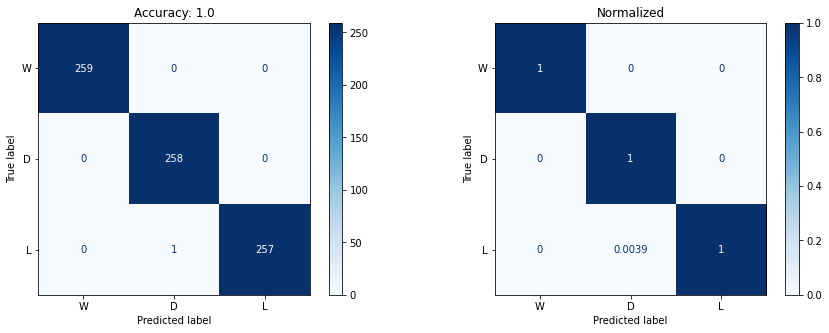

   Class  Accuracy  Precision    Recall        F1  Support
0      W  1.000000   1.000000  1.000000  1.000000      259
1      D  1.000000   0.996139  1.000000  0.998066      258
2      L  0.996124   1.000000  0.996124  0.998058      258
3  Total  0.998710   0.998715  0.998710  0.998710      775


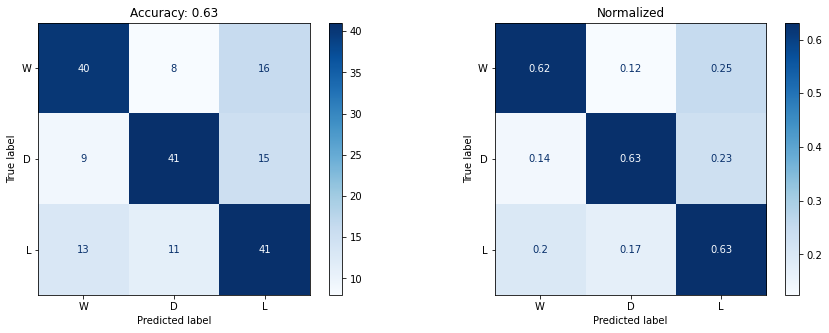

   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.625000   0.645161  0.625000  0.634921       64
1      D  0.630769   0.683333  0.630769  0.656000       65
2      L  0.630769   0.569444  0.630769  0.598540       65
3  Total  0.628866   0.632582  0.628866  0.629794      194


In [44]:
clf = RandomForestClassifier(max_depth = None, class_weight = weights).fit(X_train, y_train)
print(metric_suite(clf, X_train, y_train))
print(metric_suite(clf, X_test, y_test))

### Transform the fouls

In [18]:
X = data[data.columns[9:]].drop(
    ['result', 'home_elo', 'away_elo'],
axis = 1)
y = data['result']

Xp = X.filter(regex = 'card_color').copy()
Xp['home_fouls'] = X.filter(regex = 'home_team_foul').sum(axis = 1)
Xp['away_fouls'] = X.filter(regex = 'away_team_foul').sum(axis = 1)

In [22]:
np.random.seed(1)

size = np.min(np.unique(y, return_counts = True)[1])
X_s = StandardScaler().fit_transform(Xp)
'''W = np.random.choice(np.arange(y.shape[0])[y == 'W'], size = size)
D = np.random.choice(np.arange(y.shape[0])[y == 'D'], size = size)
L = np.random.choice(np.arange(y.shape[0])[y == 'L'], size = size)

idx = [W, D, L]
new_idx = np.concatenate(idx)
X_i = X_s[new_idx]
y_i = y[new_idx]

weights = {}
for i, class_ in enumerate(['W', 'D', 'L']):
    weights[class_] = y[y == class_].shape[0]/len(idx[i])
'''
# Stratify takes 75% from each class, works if we fix imbalance in original data
X_train, X_test, y_train, y_test = train_test_split(X_s, y, test_size = 0.2, stratify = y)
print(weights)
pd.DataFrame(np.array(np.unique(y, return_counts = True)).T, columns = ['Label', 'n']).sort_values(by = 'n')

{'W': 2.5789473684210527, 'D': 1.0, 'L': 5.315789473684211}


,Label,n
0,D,323
2,W,833
1,L,1717


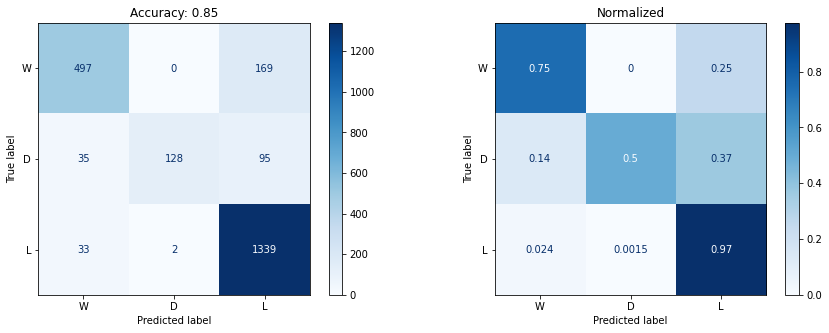

   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.746246   0.879646  0.746246  0.807474      666
1      D  0.496124   0.984615  0.496124  0.659794      258
2      L  0.974527   0.835309  0.974527  0.899563     1374
3  Total  0.854656   0.864921  0.854656  0.845955     2298


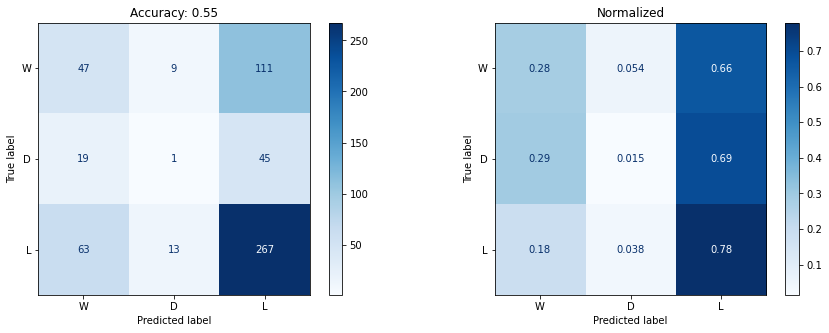

   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.281437   0.364341  0.281437  0.317568      167
1      D  0.015385   0.043478  0.015385  0.022727       65
2      L  0.778426   0.631206  0.778426  0.697128      343
3  Total  0.547826   0.487260  0.547826  0.510654      575


In [23]:
clf = RandomForestClassifier(class_weight = weights).fit(X_train, y_train)

print(metric_suite(clf, X_train, y_train))
print(metric_suite(clf, X_test, y_test))

In [24]:
from sklearn.preprocessing import PolynomialFeatures

In [34]:
np.random.seed(1)

poly = PolynomialFeatures(interaction_only=True, include_bias = False)
X_s = poly.fit_transform(Xp)
X_s = StandardScaler().fit_transform(X_s)

size = np.min(np.unique(y, return_counts = True)[1])
W = np.random.choice(np.arange(y.shape[0])[y == 'W'], size = size)
D = np.random.choice(np.arange(y.shape[0])[y == 'D'], size = size)
L = np.random.choice(np.arange(y.shape[0])[y == 'L'], size = size)

idx = [W, D, L]
new_idx = np.concatenate(idx)
X_i = X_s[new_idx]
y_i = y[new_idx]

weights = {}
for i, class_ in enumerate(['W', 'D', 'L']):
    weights[class_] = y[y == class_].shape[0]/len(idx[i])

# Stratify takes 75% from each class, works if we fix imbalance in original data
X_train, X_test, y_train, y_test = train_test_split(X_i, y_i, test_size = 0.2, stratify = y_i)
print(weights)
pd.DataFrame(np.array(np.unique(y_i, return_counts = True)).T, columns = ['Label', 'n']).sort_values(by = 'n')

{'W': 2.5789473684210527, 'D': 1.0, 'L': 5.315789473684211}


,Label,n
0,D,323
1,L,323
2,W,323


/Users/kayacelebi/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


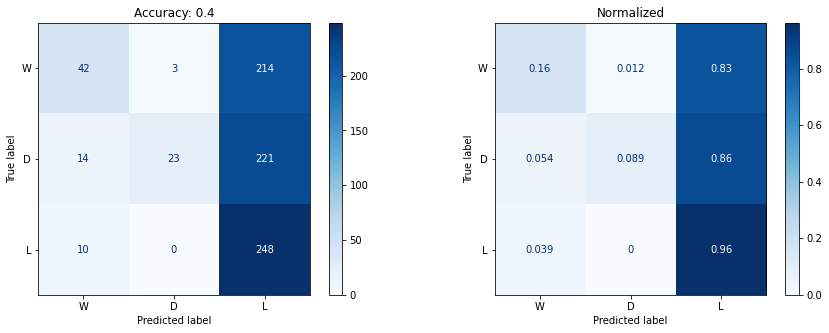

   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.162162   0.636364  0.162162  0.258462      259
1      D  0.089147   0.884615  0.089147  0.161972      258
2      L  0.961240   0.363104  0.961240  0.527099      258
3  Total  0.403871   0.628038  0.403871  0.315770      775


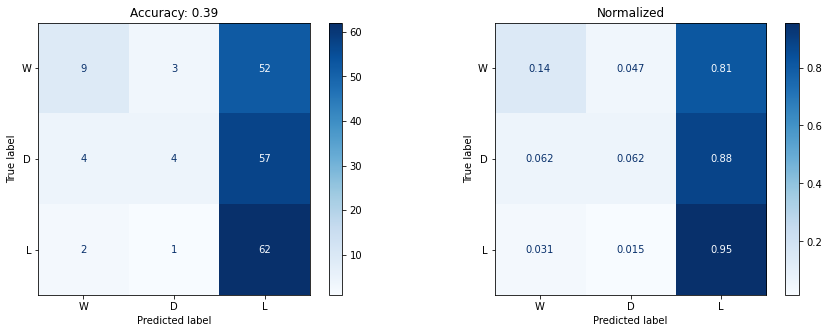

   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.140625   0.600000  0.140625  0.227848       64
1      D  0.061538   0.500000  0.061538  0.109589       65
2      L  0.953846   0.362573  0.953846  0.525424       65
3  Total  0.386598   0.486945  0.386598  0.287928      194


In [35]:
clf = LogisticRegression(multi_class = 'multinomial', class_weight = weights).fit(X_train, y_train)
print(metric_suite(clf, X_train, y_train))
print(metric_suite(clf, X_test, y_test))